In [ ]:
pip install stop-words

  Preparing metadata (setup.py) ... done
  Created wheel for stop-words: filename=stop_words-2018.7.23-py3-none-any.whl size=32895 sha256=bf3ed8bcc9deb28b9cc7d76f2f258b33b2dd7da896cea0a8417c4382b8ffa304
  Stored in directory: /root/.cache/pip/wheels/d0/1a/23/f12552a50cb09bcc1694a5ebb6c2cd5f2a0311de2b8c3d9a89
Successfully built stop-words


In [ ]:
import os
import json
import gzip
import pandas as pd
from urllib.request import urlopen
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict, Counter  # Exploración
from nltk import ngrams  # Exploración
from nltk.probability import FreqDist  # Exploración
from stop_words import get_stop_words # Preprocesado para Exploración

import nltk
nltk.download('punkt') # Preprocesado para Exploración
import string
from nltk.tokenize import sent_tokenize # Preprocesado
import re  # Preprocesado para Exploración
import spacy  # Preprocesado para Exploració
import multiprocessing
from gensim.models import Word2Vec
from gensim.models.word2vec import LineSentence
from time import time  # Tiempo de las operaciones
from sklearn.model_selection import train_test_split # Modelado
from wordcloud import WordCloud # Reporte
from sklearn.manifold import TSNE # Reporte



[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


#Función para preprocesado de los datos para el análisis

In [ ]:
stop_words = set(get_stop_words('en'))

# Caracteres numéricos
numeric_pattern = re.compile(r'\b\d+\b')

# Palabras 'play' y 'game'
play_game_words = {'play', 'game','games','toy','one'}

def clean_text(text):
    # Convertir a minúsculas
    text = text.lower()

    # Tokenizar por frase
    sentences = sent_tokenize(text)

    cleaned_sentences = []

    for sentence in sentences:

        sentence = re.sub('[%s]' % re.escape(string.punctuation + string.digits), '', sentence)
        # Tokenizar por palabra
        words = sentence.split()
        # Filtrar stopwords
        cleaned_words = [word for word in words if word not in stop_words and not numeric_pattern.match(word) and word not in play_game_words]
         #[word for word in words if word not in stop_words]
        # Reconstruir la frase limpia
        cleaned_sentence = ' '.join(cleaned_words)
        cleaned_sentences.append(cleaned_sentence)

    # Reconstruir el texto limpio
    cleaned_text = ' '.join(cleaned_sentences)
    return cleaned_text

#Cargamos el dataset

In [ ]:
!wget https://datarepo.eng.ucsd.edu/mcauley_group/data/amazon_v2/categoryFiles/Toys_and_Games.json.gz

--2024-03-29 17:37:37--  https://datarepo.eng.ucsd.edu/mcauley_group/data/amazon_v2/categoryFiles/Toys_and_Games.json.gz
Resolving datarepo.eng.ucsd.edu (datarepo.eng.ucsd.edu)... 132.239.8.30
Connecting to datarepo.eng.ucsd.edu (datarepo.eng.ucsd.edu)|132.239.8.30|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 999020493 (953M) [application/x-gzip]
Saving to: ‘Toys_and_Games.json.gz’

Toys_and_Games.json 100%[===================>] 952.74M  4.71MB/s    in 7m 6s   

2024-03-29 17:44:49 (2.24 MB/s) - ‘Toys_and_Games.json.gz’ saved [999020493/999020493]



In [ ]:
### load the meta data

data = []
max_registros = 100000
with gzip.open('Toys_and_Games.json.gz') as f:
    for i,l in enumerate(f):
      if i>= max_registros:
        break

      data.append(json.loads(l.strip()))

# total length of list, this number equals total number of products
print(len(data))

# first row of the list
print(data[0])

100000
{'overall': 2.0, 'vote': '12', 'verified': False, 'reviewTime': '09 22, 2016', 'reviewerID': 'A1IDMI31WEANAF', 'asin': '0020232233', 'reviewerName': 'Mackenzie Kent', 'reviewText': "When it comes to a DM's screen, the space on the screen itself is at an absolute premium. The fact that 50% of this space is wasted on art (and not terribly informative or needed art as well) makes it completely useless. The only reason that I gave it 2 stars and not 1 was that, technically speaking, it can at least still stand up to block your notes and dice rolls. Other than that, it drops the ball completely.", 'summary': 'The fact that 50% of this space is wasted on art (and not terribly informative or needed art ...', 'unixReviewTime': 1474502400}


In [ ]:
# creamos el dataframe
df = pd.DataFrame.from_dict(data)

In [ ]:
# Como tenemos que recortar bastante el dataset para poder trabajarlo nos quedamos con 1000 entradas para cada overall
filtered_df = df[df['overall'].isin([1, 2,  4, 5])]


num_samples = 1000
sampled_df_1 = filtered_df[filtered_df['overall'] == 1].sample(n=num_samples)
sampled_df_2 = filtered_df[filtered_df['overall'] == 2].sample(n=num_samples)
sampled_df_4 = filtered_df[filtered_df['overall'] == 4].sample(n=num_samples)
sampled_df_5 = filtered_df[filtered_df['overall'] == 5].sample(n=num_samples)


df = pd.concat([sampled_df_1, sampled_df_2,  sampled_df_4, sampled_df_5])
df.to_csv('sampled_data_file.csv', index=False,sep=';')

Para el ejercicio he intentado resolverlo quedandome con el producto con menos varianza dentro de las puntuaciones, pero para ello necesitaba cargar demasiados registros y me quedaba sin RAM, así que finalmente y para que no me quedara desbalanceado de cara a ejecutar después los modelos he sampleado los overall para traerme 1000 registros de los overall 1,2,4,5

In [ ]:
print(len(df))


4000


In [ ]:
df.columns

Index(['overall', 'vote', 'verified', 'reviewTime', 'reviewerID', 'asin',
       'reviewerName', 'reviewText', 'summary', 'unixReviewTime', 'image',
       'style'],
      dtype='object')

**DEFINICION DE LOS CAMPOS**



*   reviewerID - ID del revisor, por ejemplo, A2SUAM1J3GNN3B
*   asin - ID del producto, por ejemplo, 0000013714
*   reviewerName - nombre del revisor
*   vote -  votos útiles de la revisión
*   style - un disccionario de los metadatos del producto, por ejemplo, "Formato" es "Tapa dura""
*   reviewText - texto de la reseña
*   overall - Valoración del producto
*   summary - Resumen de la revisión
*   unixReviewTime - hora de la revisión (hora de unix)
*   reviewTime - hora de la revisión (sin procesar)
*   image - imágenes que los usuarios publican después de haber recibido el producto.


In [ ]:
#nos quedamos con el campo overall y las review
df = df.loc[:, ['overall', 'reviewText']]


In [ ]:
df.dropna(subset=['overall', 'reviewText'], inplace=True)
df.reset_index(drop=True, inplace=True)

# Análisis Exploratorio

In [ ]:
df.head()

,overall,reviewText
0,1.0,Disapointed! I purchased this product because...
1,1.0,This does not fit the ATW Cargo Wagon and shou...
2,1.0,Parts missing
3,1.0,This product box was in awful condition. It l...
4,1.0,"Very very cheaply made, the pot tilts already ..."


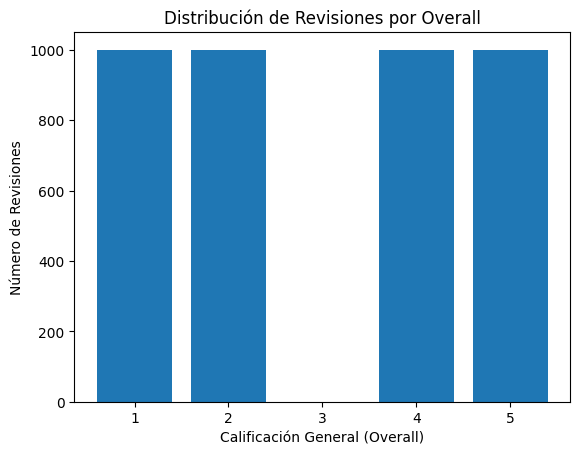

In [ ]:
# Contar el número de revisiones para cada valor único de 'overall' aunque en este caso no tiene mucho sentido porque hemos sampleado

distribucion_reviews = df['overall'].value_counts().sort_index()

# Graficar la distribución de revisiones por overall
plt.bar(distribucion_reviews.index, distribucion_reviews.values)
plt.xlabel('Calificación General (Overall)')
plt.ylabel('Número de Revisiones')
plt.title('Distribución de Revisiones por Overall')
plt.show()

In [ ]:
#Clasificamos las review como malas si tienen overall 1 y 2 (overall_label=1) y buenas 4 y 5 (overall_label=0)

def label_review(row):
    if int(row['overall']) < 3:
        return 1
    else:
        return 0

In [ ]:
df['overall_label'] = df.apply(lambda row: label_review(row), axis=1)

   overall_label
0           2000
1           1999


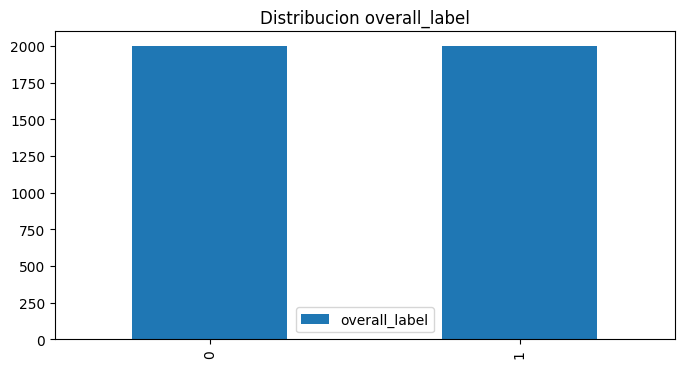

In [ ]:
# Contar el número de revisiones para cada valor único de 'overall_label'
aux_df = pd.DataFrame(df['overall_label'].value_counts(sort=False).sort_index())
aux_df2 = aux_df.plot(kind='bar', title='Distribucion overall_label', figsize=(8, 4))
print(aux_df)

#Guardamos los datos en un csv y los guardamos en drive para cargarlos en el siguiente notebook

In [ ]:
#crear csv
df.to_csv('data_file.csv', index=False,sep=';')

In [ ]:
# Subir el archivo CSV a Google Drive
from google.colab import drive
drive.mount('/content/drive')
!cp data_file.csv /content/drive/MyDrive/data_file.csv


Mounted at /content/drive


#Revisamos alguna de las Reviews

In [ ]:
df['reviewText'].get(20)

"Not like the one we had as kids. The sticks are so flimsy they don't poke all the way to the other side. Would not buy again."

Ya vemos que deberemos convertir a minúsculas, eliminar signos de puntuación y las stopwords

In [ ]:
df.head()

,overall,reviewText,overall_label
0,1.0,Disapointed! I purchased this product because...,1
1,1.0,This does not fit the ATW Cargo Wagon and shou...,1
2,1.0,Parts missing,1
3,1.0,This product box was in awful condition. It l...,1
4,1.0,"Very very cheaply made, the pot tilts already ...",1


Al hacer los N gramas veo que necesito sacar las stop words, los numeros y algunas palabras que hacen referencia a juegos y el dataset ya sabemos que es de juegos, como game,games,toy... Por eso defino la función clean_text() aunque el csv con los datos lo guardo sin el preprocesado ya que cuando acabe el análisis se incluirá en el Pipeline de preprocesado todo lo que resulte como connclusión del análisis exploratorio.

Pasamos la función para la limpieza de los datos

In [ ]:
df['reviewText'] = df['reviewText'].apply(clean_text)

Revisamos como queda el review una vez aplicada la función de limpieza

In [ ]:
filtered_reviews = df['reviewText']

In [ ]:
filtered_reviews = pd.DataFrame(filtered_reviews)

In [ ]:
filtered_reviews.head()

,reviewText
0,disapointed purchased product picture descript...
1,fit atw cargo wagon listed accessory pads smal...
2,parts missing
3,product box awful condition looked smashed rip...
4,cheaply made pot tilts already without beans w...


In [ ]:
filtered_reviews.shape

(3999, 1)

In [ ]:
words = df['reviewText'].str.split().explode().reset_index(drop=True)

In [ ]:
vocabulary_ = Counter(words)

In [ ]:
len(vocabulary_)

10430

# N-grams más frecuentes

In [ ]:
bigrams_ = ngrams(words, 2)
trigrams_ = ngrams(words, 3)

In [ ]:
bigrams_freq_ = FreqDist(bigrams_)
trigrams_freq_ = FreqDist(trigrams_)

In [ ]:
bigrams_freq_.most_common(10)

[(('year', 'old'), 345),
 (('waste', 'money'), 80),
 (('put', 'together'), 76),
 (('yr', 'old'), 60),
 (('cheaply', 'made'), 59),
 (('much', 'fun'), 59),
 (('kids', 'love'), 58),
 (('old', 'son'), 57),
 (('month', 'old'), 52),
 (('much', 'better'), 51)]

In [ ]:
trigrams_freq_.most_common(10)


[(('year', 'old', 'son'), 36),
 (('year', 'old', 'daughter'), 31),
 (('year', 'old', 'loves'), 27),
 (('dont', 'waste', 'money'), 25),
 (('bought', 'year', 'old'), 24),
 (('old', 'son', 'loves'), 19),
 (('year', 'old', 'grandson'), 16),
 (('month', 'old', 'son'), 11),
 (('gift', 'year', 'old'), 11),
 (('year', 'old', 'granddaughter'), 11)]

Revisando los N gramas vemos que el de 2 nos aporta mas información sobre si es juego es bueno, malo, divertido, sobre el coste, en cambio el de 3 vemos que las combinaciones hacen referencia principalmente a las edades de los consumidores o destinatarios del juego

# Word2Vec

In [ ]:
cores = multiprocessing.cpu_count() # Contamos el número de cores en el ordenador
print (cores)

2


Hyperparametros para el Word2Vec

In [ ]:
w2v_model = Word2Vec(min_count=10,
                     window=2,
                     vector_size=300,  # Tamaño del vector
                     sample=6e-5,
                     alpha=0.03,
                     min_alpha=0.0007,
                     negative=20,
                     workers=-1)

Construimos el vocabulario

In [ ]:
t = time()
sent = [row.split() for row in filtered_reviews['reviewText']]
w2v_model.build_vocab(sent, progress_per=100)

print('Tiempo para construir el vocabulario: {} mins'.format(round((time() - t) / 60, 2)))


Tiempo para construir el vocabulario: 0.0 mins


In [ ]:
vocab_size = len(w2v_model.wv.key_to_index)
print('Vocabulario compuesto por {} palabras'.format(vocab_size))

Vocabulario compuesto por 1641 palabras


#Entrenamos el modelo

In [ ]:
t = time()

w2v_model.train(sent, total_examples=w2v_model.corpus_count, epochs=30, report_delay=1)


print('Time to train the model: {} mins'.format(round((time() - t) / 60, 2)))

Time to train the model: 0.01 mins


Guardamos el modelo


In [ ]:
w2v_model.save('./w2v_model.pkl')

Visualización en 2 dimensiones de algunos word embeddings calculados con
 Word2Vec (elegir 4-5 palabras y pintar las top 10 más similares)


In [ ]:
# Vemos palabras mas frecuentes
most_common_words = vocabulary_.most_common(10)

# Imprimir las palabras más frecuentes
for word, frequency in most_common_words:
    print(f'Palabra: {word}, Frecuencia: {frequency}')

Palabra: fun, Frecuencia: 809
Palabra: just, Frecuencia: 775
Palabra: great, Frecuencia: 738
Palabra: like, Frecuencia: 709
Palabra: can, Frecuencia: 695
Palabra: get, Frecuencia: 678
Palabra: old, Frecuencia: 657
Palabra: will, Frecuencia: 594
Palabra: kids, Frecuencia: 550
Palabra: time, Frecuencia: 529


#Nube de palabras con las más frecuntes

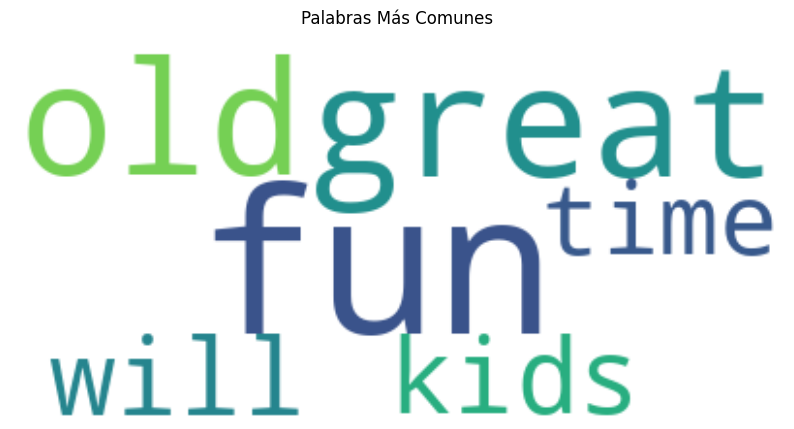

In [ ]:
# Crear una cadena de texto con las palabras y sus frecuencias
wordcloud_text = ' '.join([word for word, freq in most_common_words])

# Crear el objeto WordCloud
wordcloud = WordCloud(width=400, height=200, background_color='white').generate(wordcloud_text)

# Mostrar la nube de palabras
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Palabras Más Comunes')
plt.show()

# Seleccionar palabras para visualizar y crear clusters de palabras con las más similares a las seleccionadas

In [ ]:

palabras_a_visualizar = ['get','fun', 'can', 'great','just']

embedding_clusters = []
word_clusters = []
for word in palabras_a_visualizar:
    embeddings = []
    words = []
    for similar_word, _ in w2v_model.wv.most_similar(word, topn=10):
        words.append(similar_word)
        embeddings.append(w2v_model.wv[similar_word])
    embedding_clusters.append(embeddings)
    word_clusters.append(words)

In [ ]:
print(word_clusters)

[['daughters', 'surface', 'finding', 'lasted', 'important', 'santa', 'dead', 'average', 'noise', 'wild'], ['heavy', 'cards', 'cord', 'family', 'stupid', 'hasbro', 'wars', 'plays', 'pack', 'becomes'], ['cool', 'rc', 'levels', 'yrs', 'heavy', 'found', 'fly', 'marble', 'push', 'overly'], ['graphics', 'intended', 'usually', 'preferred', 'gives', 'leave', 'ive', 'sister', 'bags', 'windows'], ['apart', 'lay', 'toys', 'matter', 'weeks', 'hidden', 'anyway', 'compared', 'month', 'order']]


#Reducir a 2D para representar

In [ ]:
tsne_model_2d = TSNE(perplexity=15, n_components=2, init='pca', n_iter=3500, random_state=32)


In [ ]:
embedding_clusters = np.array(embedding_clusters)
n, m, k = embedding_clusters.shape

In [ ]:
embeddings_2d = np.array(tsne_model_2d.fit_transform(embedding_clusters.reshape(n * m, k))).reshape(n, m, 2)

#Crear Visualización

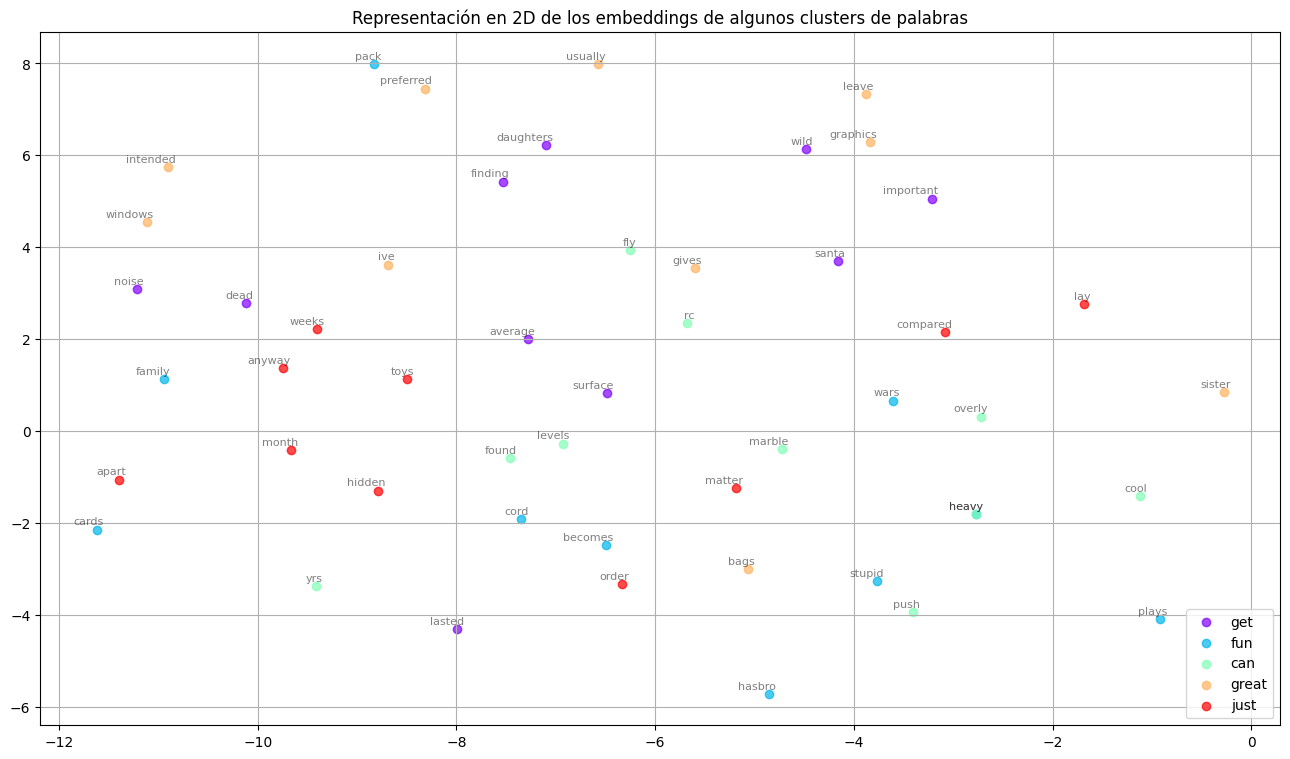

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
%matplotlib inline


def tsne_plot_similar_words(labels, embedding_clusters, word_clusters, a=0.7):
    plt.figure(figsize=(16, 9))
    colors = cm.rainbow(np.linspace(0, 1, len(labels)))
    for label, embeddings, words, color in zip(labels, embedding_clusters, word_clusters, colors):
        x = embeddings[:,0]
        y = embeddings[:,1]
        plt.scatter(x, y, c=[color], alpha=a, label=label)
        for i, word in enumerate(words):
            plt.annotate(word, alpha=0.5, xy=(x[i], y[i]), xytext=(5, 2),
                         textcoords='offset points', ha='right', va='bottom', size=8)
    plt.legend(loc=4)
    plt.grid(True)
    plt.title('Representación en 2D de los embeddings de algunos clusters de palabras')

    plt.show()


tsne_plot_similar_words(palabras_a_visualizar, embeddings_2d, word_clusters)

Después de realizar el análisis exploratorio, voy a incluir en el pipeline de preprocesado:



*   Quitar los números
*   quitar algunas palábras que durante el análisis he visto que no aportaban valor

*   Quitar las stop-words
*   Quitar los signos de puntuación

*   Quitar carácteres raros
*   Tokenizar
*   Lematizar






